## 2: Dataset2 3-Digit Classification

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

Shape: (84, 84)
Range: 0.0-1.0


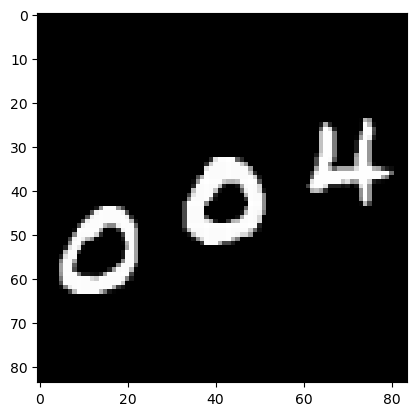

In [6]:
img = mpimg.imread('dataset2/triple_mnist/train/004/14_004.png')
imgplot = plt.imshow(img, cmap='gray')
print('Shape: ' + str(img.shape))
print('Range: ' + str(np.min(img)) + '-' + str(np.max(img)))

### Data Importing

In [7]:
import os

def get_data(subdir):
    # this imports all the data from a specified subdirectory and places into [img, label] pairs in a list.
    dir = 'dataset2/triple_mnist'  # base directory for all data.
    X = []
    y = []
    labels = os.listdir(os.path.join(dir, subdir))  # get all folders (labels) in the subdirectory.
    
    for label in labels:  # cycles through each folder (label).

        for img in os.listdir(os.path.join(dir, subdir, label)):  # cycles through each png.
            try:
                img_arr = plt.imread(os.path.join(dir, subdir, label, img))  # reads image data.
                X.append(img_arr)  # appends image data with label.
                y.append([int(digit) for digit in label])
            except Exception as e:
                print(e)

    return np.array(X), np.array(y)

In [8]:
X_train, y_train = get_data('train')
X_val, y_val = get_data('val')
X_test, y_test = get_data('test')

In [9]:
print(X_train.shape)
print(y_train.shape)

(64000, 84, 84)
(64000, 3)


### Thresholding

(0.1, 1.0)

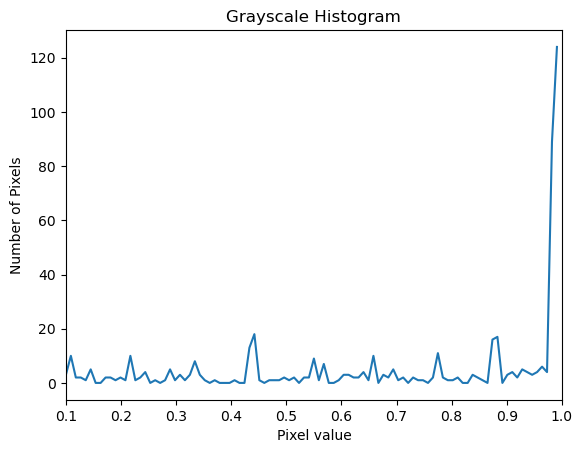

In [10]:
sample_img = mpimg.imread('dataset2/triple_mnist/train/248/14_248.png')
histogram, bin_edges = np.histogram(sample_img, bins=100, range=(0.1, 1.0))  # histogram of pixel values.

# PLOTTING HISTOGRAM
fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)
ax.set_title("Grayscale Histogram")
ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of Pixels")
ax.set_xlim(0.1, 1.0)  # 0.1 is used as lower limit because there are thousands of 0 pixels that flood the graph.

In [11]:
def thresholding(X_data, threshold):
    X_new = []

    for img in X_data:
        binary_img = img > threshold
        X_new.append(binary_img)

    return np.array(X_new)

In [12]:
t = 0.85
X_train_mod = thresholding(X_train, threshold=t)
X_val_mod = thresholding(X_val, threshold=t)
X_test_mod = thresholding(X_test, threshold=t)

Text(0.5, 1.0, 'After Thresholding')

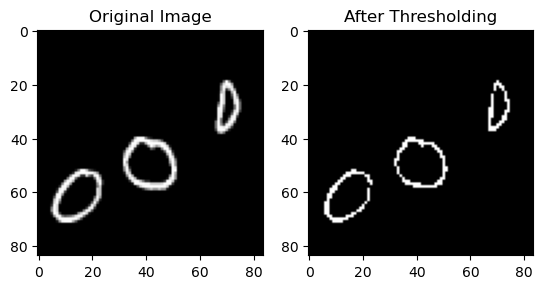

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(X_train_mod[0], cmap='gray')
plt.title('After Thresholding')

### CNN Model

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [36]:
# Define the model
input_layer = Input(shape=(84, 84, 1))

# Convolutional layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Output layers for each digit
digit1 = Dense(10, activation='softmax', name='digit1')(x)
digit2 = Dense(10, activation='softmax', name='digit2')(x)
digit3 = Dense(10, activation='softmax', name='digit3')(x)

In [37]:
# Create the model
model = Model(inputs=input_layer, outputs=[digit1, digit2, digit3])

# Compile the model
model.compile(optimizer='adam',
              loss={'digit1': 'sparse_categorical_crossentropy', 'digit2': 'sparse_categorical_crossentropy', 'digit3': 'sparse_categorical_crossentropy'},
              metrics={'digit1': 'accuracy', 'digit2': 'accuracy', 'digit3': 'accuracy'},
              run_eagerly=True)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 84, 84, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 82, 82, 32)           320       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 41, 41, 32)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 39, 39, 64)           18496     ['max_pooling2d_6[0][0]'

In [38]:
# TRAINING
history = model.fit(X_train_mod, 
                    {'digit1': y_train[:, 0], 'digit2': y_train[:, 1], 'digit3': y_train[:, 2]},
                    validation_data=(X_val_mod, {'digit1': y_val[:, 0], 'digit2': y_val[:, 1], 'digit3': y_val[:, 2]}),
                    epochs=10,
                    batch_size=64)

Epoch 1/10
1000/1000 [==============================] - 367s 367ms/step - loss: 1.8654 - digit1_loss: 0.6181 - digit2_loss: 0.6184 - digit3_loss: 0.6289 - digit1_accuracy: 0.7937 - digit2_accuracy: 0.7924 - digit3_accuracy: 0.7891 - val_loss: 0.9241 - val_digit1_loss: 0.3157 - val_digit2_loss: 0.2907 - val_digit3_loss: 0.3177 - val_digit1_accuracy: 0.9013 - val_digit2_accuracy: 0.9087 - val_digit3_accuracy: 0.9034
Epoch 2/10
1000/1000 [==============================] - 366s 366ms/step - loss: 0.5667 - digit1_loss: 0.1868 - digit2_loss: 0.1874 - digit3_loss: 0.1925 - digit1_accuracy: 0.9419 - digit2_accuracy: 0.9416 - digit3_accuracy: 0.9393 - val_loss: 0.7675 - val_digit1_loss: 0.2520 - val_digit2_loss: 0.2429 - val_digit3_loss: 0.2726 - val_digit1_accuracy: 0.9189 - val_digit2_accuracy: 0.9229 - val_digit3_accuracy: 0.9149
Epoch 3/10
1000/1000 [==============================] - 349s 349ms/step - loss: 0.3102 - digit1_loss: 0.1007 - digit2_loss: 0.1032 - digit3_loss: 0.1063 - digit1_ac

In [42]:
# TESTING
test_scores = model.evaluate(X_test_mod, 
                                                      {'digit1': y_test[:, 0], 'digit2': y_test[:, 1], 'digit3': y_test[:, 2]})

625/625 [==============================] - 58s 92ms/step - loss: 1.0561 - digit1_loss: 0.3280 - digit2_loss: 0.3475 - digit3_loss: 0.3806 - digit1_accuracy: 0.9342 - digit2_accuracy: 0.9305 - digit3_accuracy: 0.9216


[1.0561432838439941,
 0.32801809906959534,
 0.34751567244529724,
 0.3806092441082001,
 0.9341999888420105,
 0.9305499792098999,
 0.9216499924659729]

In [44]:
print(f"Test loss: {test_scores[0]}")
print(f"Test accuracy for digit 1: {test_scores[-3]}")
print(f"Test accuracy for digit 2: {test_scores[-2]}")
print(f"Test accuracy for digit 3: {test_scores[-1]}")

Test loss: 1.0561432838439941
Test accuracy for digit 1: 0.9341999888420105
Test accuracy for digit 2: 0.9305499792098999
Test accuracy for digit 3: 0.9216499924659729


In [45]:
y_pred = model.predict(X_test_mod)

625/625 [==============================] - 40s 64ms/step


In [76]:
# need to combine the digit predictions into a 3 digit output for each image to get final accuracy for the model.